Importation de Modules utiles et définitions de certains termes.

In [18]:
from scipy.constants import Avogadro, c, m_e, m_p, e, physical_constants

import numpy as np
import matplotlib.pyplot as plt     #Permet de générer des graphiques.

eV_to_MeV = 1e-6            #Convertion eV vers MeV.

m_p = m_p  * eV_to_MeV/e    # Masse du proton en MeV/c^2
m_e = m_e  * eV_to_MeV/e    # Masse de l'électron en MeV/c^2

r_e = physical_constants["classical electron radius"][0] * 1e2      # cm

# Q1
Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD-------------

In [22]:
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

I_bone = 91.9 * eV_to_MeV                                                                                               # Mean Excitation Energy en MeV de l'eau liquide.
rho_bone = 1.85                                                                                                         # Densité de l'os Compact en g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])                                                            # Nombre atomique.
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])   # Fractions Massiques.
AtomicMasses_bone = np.array([1.007975, 12.0106, 14.006855, 15.99940, 24.3055, 30.973762, 32.0675, 40.078])             # Masses Atomiques.

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, AtomicMasses_bone)                              # Densité électronique de l'Os Compact

I_water = 75 * eV_to_MeV                                                                                                # Mean Excitation Energy en MeV de l'eau liquide.
rho_water = 1                                                                                                           # Densité de l'eau liquide en g/cm^3
atomic_numbers_water = np.array([1, 8])                                                                                 # Nombre atomique.
fractions_by_weight_water = np.array([0.111894, 0.888106])                                                              # Fractions Massiques.
AtomicMasses_water = np.array([1.008, 15.999])                                                                          # Masses Atomiques.

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, AtomicMasses_water)                         # Densité électronique de l'eau liquide

print(f"Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de {n_e_bone} e-/cm\u00b3 et {n_e_water} e-/cm\u00b3.")

Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de 5.905891191511755e+23 e-/cm³ et 3.342810286137214e+23 e-/cm³.


# Q2

In [20]:
def S_col(T, n_e, I_MeV):
    gamma = T/(m_p*c**2) + 1
    T_max = (2*m_e*c**2 * (gamma**2 - 1))/(1 + 2*(m_e/m_p)*gamma + (m_e/m_p)**2)
    beta = (gamma**2/(gamma**2 - 1))**-1
    U = (2 * np.pi * r_e**2 * m_e * c**2 * n_e)
    S_col =  U / (beta**2+np.finfo(np.float64).eps) * (
        np.log(np.finfo(np.float64).eps + (2 * m_e * c**2 * beta**2 * gamma**2 * T_max) / I_MeV**2) - 2 * beta**2)
    return S_col

from functools import partial
SCol_bone = partial(S_col, n_e=n_e_bone, I_MeV=I_bone)
SCol_water = partial(S_col, n_e=n_e_water, I_MeV=I_water)

In [21]:
beta = np.linspace(0.09778,0.98,10_000)
gamma = 1 / np.sqrt(1 - beta**2 + np.finfo(np.float64).eps)
T = (gamma - 1)*m_p * c**2

S_col_water = SCol_water(T)
S_col_bone = SCol_bone(T)
print(f"Kinetic energy T: {T}")
print(f"Stopping Power S_col_bone: {S_col_bone} MeV/cm")
print(f"Stopping Power S_col_water: {S_col_water} MeV/cm")

Kinetic energy T: [   4.51779782    4.52601379    4.53423739 ... 3756.2680035  3766.46147308
 3776.72255986]
Stopping Power S_col_bone: [7.74330572e+03 7.72435832e+03 7.70546409e+03 ... 3.77411951e+00
 3.77415511e+00 3.77419656e+00] MeV/cm
Stopping Power S_col_water: [4.76173822e+03 4.74964914e+03 4.73759630e+03 ... 2.17378084e+00
 2.17378746e+00 2.17379739e+00] MeV/cm


In [5]:
gamma3mev = (3/(m_p * c**2) + 1)
beta3mev = np.sqrt((gamma3mev**3 - 1))/gamma3mev
beta3mev

0.09778323521115201

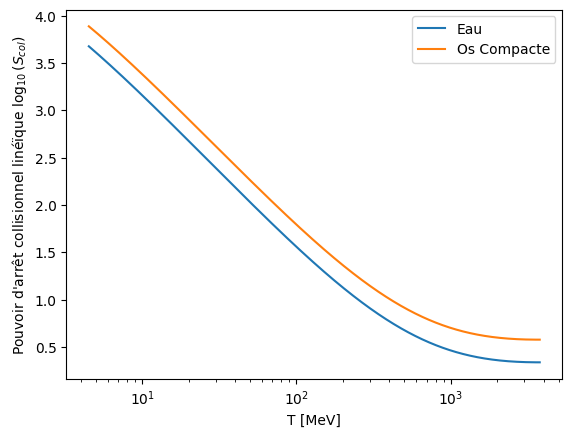

In [6]:
def plotit(T,bone=S_col_bone,water=S_col_water):
    plt.semilogx(T, np.log10(water) , label="Eau")
    plt.semilogx(T, np.log10(bone ), label="Os Compacte")
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéïque $\\log_{10}(S_{col})$")
    plt.legend()
    plt.show()
plotit(T)

# Q3


Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.


Pour l'eau liquide:

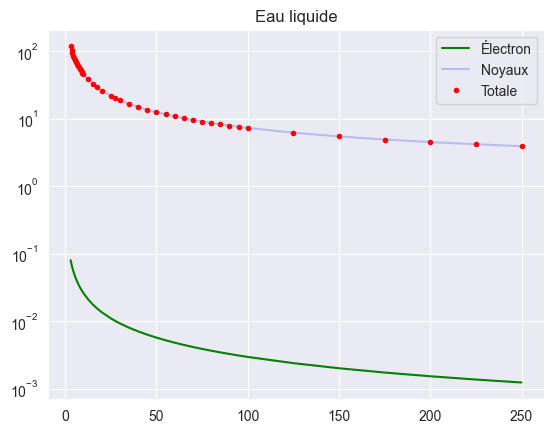

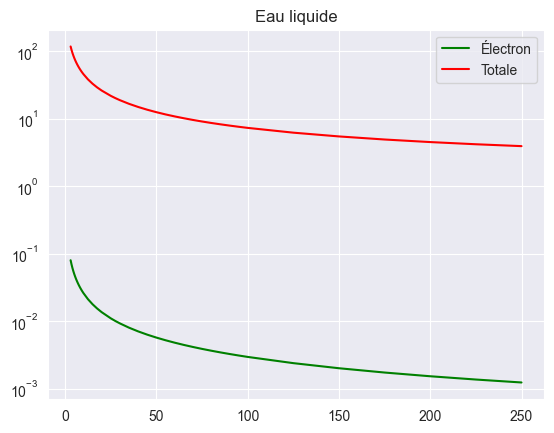

In [2]:
Ke_Mev_eau_liquide , \
Stopping_power_Nuclear_eau_liquide, \
Stopping_power_Electronic_eau_liquide, \
Stopping_power_total_eau_liquide = np.loadtxt("data_eau_liquide.txt", unpack=True)

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide,'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'b', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Totale")
plt.legend()
plt.show()
plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, 'r-',label="Totale")
plt.legend()

plt.show()


Nous pouvons voir qu'il n'est pas nécessaire de considérer l'effet atomique. En effet, sa contribution est très minime. Le premier graph montre les contribution de toutes les parties alors que le deuxième graph montre le stopping power total et électronique.

Pour l'os compact:

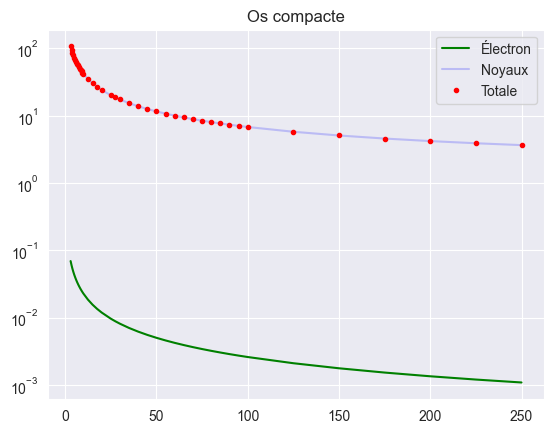

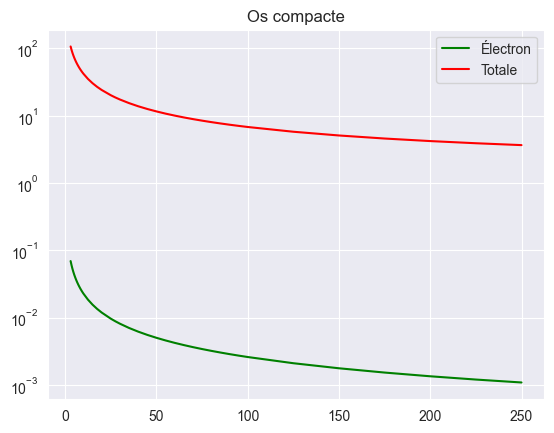

In [3]:

Ke_Mev_os_compact , \
Stopping_power_Nuclear_os_compact, \
Stopping_power_Electronic_os_compact, \
Stopping_power_total_os_compact = np.loadtxt("data_os_compact.txt", unpack=True)

plt.title("Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact,'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'b', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Totale")
plt.legend()
plt.show()
plt.title("Os compacte")

plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, 'r-',label="Totale")
plt.legend()

plt.show()

# Q4

À partir de l'équation suivante $ \frac{S_{col}}{\rho} = - \left( \frac{1}{\rho} \frac{dT}{dx} \right)_{col} $ on peut réexprimer dx en fonction du reste. $$ dx = -\frac{dT}{S_{col}} $$ On obtient ensuite $$ x = -\int^{T_i}_0 \frac{dT}{S_{col}}$$


In [9]:

def inverse(func):
    def wrapper(*args):
        res = func(*args)
        return 1/res
    return wrapper
    

# Q5 

## À améliorer:
Équation complexe, il n’existe pas de solution analytique générale permettant de relier directement l’énergie initiale d’un proton à sa portée dans un milieu donné. $\frac{1}{\ln(x)}$ ne s'intègre pas.

# Q6

In [106]:
def Romberg(f, a, b, tol=np.finfo(float).eps,allR=False):
    def h(k):
        return (b - a) / (2 ** k)
    MAX_STEP = 40
    R = np.zeros((MAX_STEP, MAX_STEP))
    R[0, 0] = 0.5 * (b - a) * (f(a) + f(b))
    
    for n in range(1, MAX_STEP):
        h_n = h(n)
        midpoints = np.array([a + (2 * k - 1) * h_n for k in range(1, 2 ** (n-1) + 1)])
        R[n, 0] = 0.5 * R[n - 1, 0] + h_n * np.sum(f(midpoints))
        for m in range(1, n + 1):
            R[n, m] = (4 ** m * R[n, m - 1] - R[n - 1, m - 1]) / (4 ** m - 1)

        if abs(R[n, n] - R[n - 1, n - 1]) <= tol:
            print(f"nombre de slice: {2**n}")
            if allR:
                return R
            return R[n, n]
    if allR:
        return R
    return R[n, n]

def trapz(f,a,b,tol=np.finfo(float).eps, TRY=10, allR=False):
    I = 0.5 * (b - a) * (f(a) + f(b)) # un seul trapèze
    h_n = (b - a)/2
    R = np.zeros(TRY)
    R[0] = I
    for n in range(1, TRY):
        h_n /= 2
        sum_midpoints = np.sum(f(np.linspace(a + h_n, b - h_n, 2**(n))))
        new_I = 0.5 * I + h_n * sum_midpoints
        R[n] = new_I
        error_estimate = abs(I - new_I) / 3
        if error_estimate <= tol:
            print("convergence sous la précision machine")
            print(f"nombre de slice: {2**n}", new_I)
            if allR:
                return R
            return new_I
        I = new_I
    print(f"nombre de slice: {2**TRY}, error estimate: {error_estimate}")
    if allR:
        return R
    return I

# Os compacte

In [18]:
Romberg(inverse(SCol_bone), 3, 150)

nombre de slice: 4096


1.7522435162955488

In [107]:
trapz(inverse(SCol_bone), 3, 150,TRY=20)

nombre de slice: 1048576, error estimate: 1.8445989032519114e-07


1.7522440696744148

# Eau liquide

In [25]:
Romberg(inverse(SCol_water), 3, 150)

nombre de slice: 4096


3.0071691642741354

In [ ]:
trapz(SCol_water, 3, 150,TRY=30)

# Q7
Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.

## Os compacte et eau liquide

In [116]:
def getNRes(R):
    res = np.diag(R)
    res = res[res!=0]
    N = [2**i for i in range(res.shape[0])]
    return N, res

nombre de slice: 4096
nombre de slice: 4096
nombre de slice: 1048576, error estimate: 1.8445989032519114e-07
nombre de slice: 1048576, error estimate: 3.203154887998494e-07


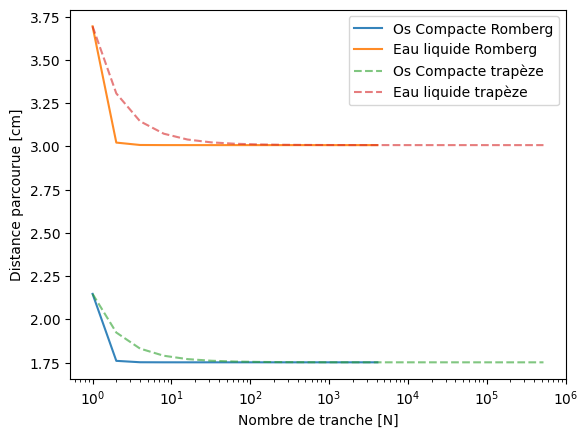

In [119]:

plt.semilogx(*getNRes(Romberg(inverse(SCol_bone), 3, 150, allR=True)), "-",label="Os Compacte Romberg", alpha=0.9)
plt.semilogx(*getNRes(Romberg(inverse(SCol_water), 3, 150, allR=True)), "-",label="Eau liquide Romberg", alpha=0.9)
plt.semilogx(*getNRes(trapz(inverse(SCol_bone), 3, 150, TRY=20,allR=True)), "--",label="Os Compacte trapèze", alpha=0.6)
plt.semilogx(*getNRes(trapz(inverse(SCol_water), 3, 150, TRY=20,allR=True)), "--",label="Eau liquide trapèze", alpha=0.6)

plt.legend()
plt.xlabel("Nombre de tranche [N]")
plt.ylabel("Distance parcourue [cm]")
plt.show()

# **Estimation analytique de l'erreur** 
## À faire pour la Q7

## Q8
la dérivé de $ S^{-1}_{col}$, selon mon calcul à la main est : $$  \frac{d S^{-1}_{col}}{dT} = \frac{-1}{2\pi r_e^2 m_e c^4 n_e m_p } 
\left( \frac{\left(\frac{-2\gamma^3}{(\gamma^2 - 1)^2} + \frac{2\gamma}{\gamma^2 -1}\right) 
\ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) + \frac{1}{\gamma^2 -1} \left( 4\gamma -\frac{\delta}{b+\delta \gamma}\right) }{\left[ \ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) \frac{\gamma^2}{\gamma^2 -1} -2\right]^2}\right)$$

In [149]:
import sympy as sp

# Define symbols
T = sp.Symbol('T', real=True, positive=True)  # Temperature
ne = sp.Symbol('n_e', real=True, positive=True)  # Electron number density
IMeV = sp.Symbol('I_{MeV}', real=True, positive=True)  # Ionization energy in MeV
re = sp.Symbol('r_e', real=True, positive=True)  # Classical electron radius
me = sp.Symbol('m_e', real=True, positive=True)  # Electron mass
mp = sp.Symbol('m_p', real=True, positive=True)  # Proton mass
c = sp.Symbol('c', real=True, positive=True)  # Speed of light

# Define gamma factor
gamma = T / (mp * c**2) + 1

# Define T_max
T_max = (2 * me * c**2 * (gamma**2 - 1)) / (1 + 2 * (me / mp) * gamma + (me / mp)**2)

# Define beta
beta = 1 / (gamma**2 / (gamma**2 - 1))

# Define U
U = 2 * sp.pi * re**2 * me * c**2 * ne

# Define S_col expression
S_col = U / (beta**2) * (sp.log((2 * me * c**2 * beta**2 * gamma**2 * T_max) / IMeV**2) - 2 * beta**2)

# Display the expression


In [151]:
f = S_col**-1

In [162]:
f = sp.simplify(f)

In [165]:
dfdT = sp.diff(f,T)

In [167]:
dfdT = sp.together(dfdT)